In [9]:
% matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy.ma as ma

import gsw as sw
from mpl_toolkits.basemap import Basemap, cm, interp

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
rcParams.update({'font.family': 'serif'})
rcParams.update({'font.serif': 'Times New Roman'})

In [10]:
# import data

minlon = 130
maxlon = 171

Tok1 = pd.read_csv(r'/Users/sclayton/Google Drive/o2ar_data/Tokyo1_vSept16.csv', sep = ',')
Tok1['density'] = sw.rho(Tok1['S'].values,Tok1['T'].values,0)-1000
Tok1 = Tok1[(Tok1['Lon']>minlon) & (Tok1['Lon']<maxlon)]

Tok2 = pd.read_csv(r'/Users/sclayton/Google Drive/o2ar_data/Tokyo2_vSept16.csv', sep = ',')
Tok2['density'] = sw.rho(Tok2['S'].values,Tok2['T'].values,0)-1000
Tok2 = Tok2[(Tok2['Lon']>minlon) & (Tok2['Lon']<maxlon)]

Tok3 = pd.read_csv(r'/Users/sclayton/Google Drive/o2ar_data/Tokyo3_vSept16.csv', sep = ',')
Tok3['density'] = sw.rho(Tok3['S'].values,Tok3['T'].values,0)-1000
Tok3 = Tok3[(Tok3['Lon']>minlon) & (Tok3['Lon']<maxlon)]

Tian = pd.read_csv(r'/Users/sclayton/Google Drive/o2ar_data/Tianjin2_vSept16.csv', sep = ',')
Tian['density'] = sw.rho(Tian['S'].values,Tian['T'].values,0)-1000
Tian = Tian[(Tian['Lon']>minlon) & (Tian['Lon']<maxlon)]

print Tian.columns

# combine into mega dataset
data = pd.concat([Tok1,   Tian], ignore_index = True)

Index([u'Timestamp', u'Lat', u'Lon', u'S', u'T', u'Fluo', u'TrueO2Ar',
       u'O2Arsat', u'O2Arbiosat', u'MLD (WOA13)', u'Wkn', u'Air-sea flux',
       u'density'],
      dtype='object')


In [11]:
subset = data 

# bin the nitrate data into sigma vs latitude bins

dy = 0.5
dx = 1.

ybin = np.arange(21., 27., dy)
xbin = np.arange(30., 45., dx)

xgrid, ygrid = np.meshgrid(xbin, ybin, sparse=False, indexing='ij')

binned = np.empty([len(xbin), len(ybin)])
binnedstd = np.empty([len(xbin), len(ybin)])
fvar = 'Air-sea flux'

for i in range(len(xbin)):
    lat = xbin[i]
    for j in range(len(ybin)):
        sig = ybin[j]

        nn = len(subset.loc[((subset['Lat']>lat-dx/2) & (subset['Lat']<lat +dx/2) & (subset['density']>sig -dy/2)
                                        & (subset['density']<sig +dy/2)), fvar].values)

        if nn > 0:
            binned[i,j] = np.nanmean(subset.loc[((subset['Lat']>lat-dx/2) & (subset['Lat']<lat +dx/2) & (subset['density']>sig -dy/2)
                                        & (subset['density']<sig +dy/2)), fvar].values)
            binnedstd[i,j] = np.nanstd(subset.loc[((subset['Lat']>lat-dx/2) & (subset['Lat']<lat +dx/2) & (subset['density']>sig -dy/2)
                                        & (subset['density']<sig +dy/2)), fvar].values)
        else:
            binned[i,j] = np.nan
            binnedstd[i,j] = np.nan


/Users/sclayton/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/Users/sclayton/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1136: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)


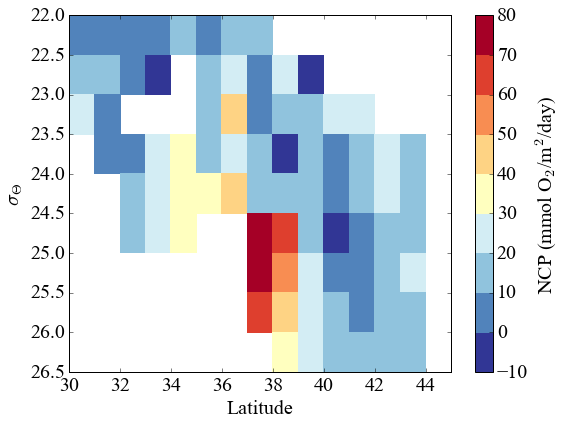

In [13]:
fig1 = plt.figure(1, figsize=(8,6))
#plt.scatter(subset['LAT'],subset['SIGMA_THETA[KG/M^3]'], c = subset['NITRATE[UMOL/KG]'], s=200, vmin = 0, vmax = 8, lw=0, alpha = 0.75)

palette = plt.get_cmap('RdYlBu_r', 9)

binned = ma.masked_where(np.isnan(binned), binned)
binnedstd = ma.masked_where(np.isnan(binnedstd), binnedstd)

plt.pcolor(xgrid, ygrid, binned, vmin = -10, vmax = 80, lw=0, cmap = palette)


#plt.contour()
cb = plt.colorbar(ticks = range(-10, 81, 10))
cb.set_label('NCP (mmol O$_2$/m$^{2}$/day)', fontsize = 20)
#plt.gca().invert_yaxis()
plt.axis([ 30,45, 26.5, 22.0])

#plt.axhline(23.5, color='grey', lw=2)
#plt.axhline(25, color='grey', lw=2) 

# plt.axvline(33., color='grey', lw=2)
# plt.axvline(38, color='grey', lw=2) 

plt.ylabel(r'$\sigma_{\Theta}$', fontsize = 20)
plt.xlabel('Latitude', fontsize = 20)
plt.tick_params(labelsize=20)
cb.ax.tick_params(labelsize=20)


plt.show()

#fig1.savefig('../figures/kuro_ncp_binned_allcruises.png', bbox_inches='tight', dpi=600)

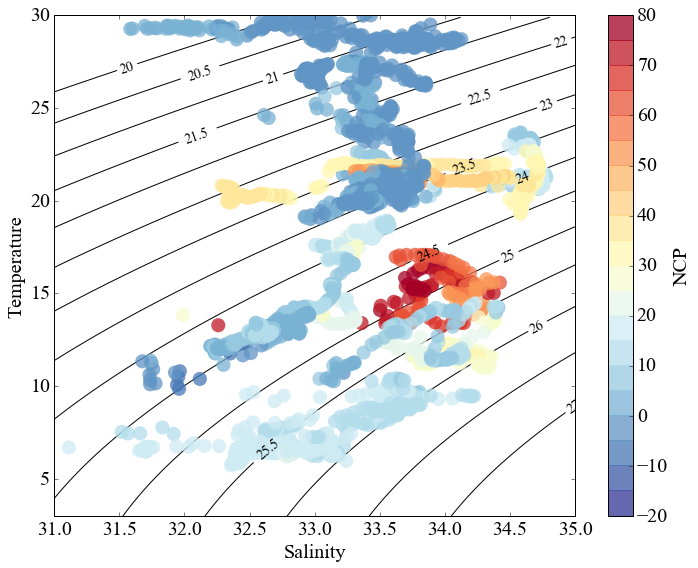

2944


In [5]:
# make T/S plots

ss = np.arange(31, 36, 0.01)
tt = np.arange(0, 30, 0.1)

s, t = np.meshgrid(ss,tt, indexing='ij')
den = sw.rho(s,t,0) - 1000

#### Tokyo1 - May 2011
fig2 = plt.figure(2, figsize = (10, 8), dpi = 600)

palette = plt.get_cmap('RdYlBu_r', 20)
levels = np.arange(20.0, 27.5, 0.5)
CS = plt.contour(s, t, den, levels, colors= 'k', zorder = 0)

class nf(float):
    def __repr__(self):
        str = '%.1f' % (self.__float__(),)
        if str[-1] == '0':
            return '%.0f' % self.__float__()
        else:
            return '%.1f' % self.__float__()

# Recast levels to new class
CS.levels = [nf(val) for val in CS.levels]

# Label levels with specially formatted floats
if plt.rcParams["text.usetex"]:
    fmt = r'%r'
else:
    fmt = '%r'
plt.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=14)

#plt.clabel(CS, inline=1, fontsize=14)
plt.scatter(Tok1['S'],Tok1['T'], s = 200, lw = 0, c = Tok1['Air-sea flux'], alpha = 0.75, vmin=-20, vmax = 80, cmap = palette, zorder =1)
# plt.scatter(Tok3['S'],Tok3['T'], s = 200, lw = 0, c = Tok3['Air-sea flux'], alpha = 0.75, vmin=-20, vmax = 80, cmap = palette, zorder =1)
plt.scatter(Tian['S'],Tian['T'], s = 200, lw = 0, c = Tian['Air-sea flux'], alpha = 0.75, vmin=-20, vmax = 80, cmap = palette, zorder =1)

plt.axis([31, 35, 3, 30])
plt.xlabel('Salinity', fontsize=20)
plt.ylabel('Temperature', fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=20)
cb.set_label('NCP', fontsize=20)

plt.show()

#fig2.savefig('../figures/NCP_TS_May11_Sept11.png', bbox_inches='tight', dpi=600)


print len(Tok1)+len(Tok3)


In [6]:
#print Tok3[(Tok3['Lon']>155) & (Tok3['Lon']<160)]

from datetime import datetime, timedelta

matlab_datenum = 734771.2052
python_datetime = datetime.fromordinal(int(matlab_datenum)) + timedelta(days=matlab_datenum%1) - timedelta(days = 366)

print python_datetime


2011-09-25 04:55:29.279997


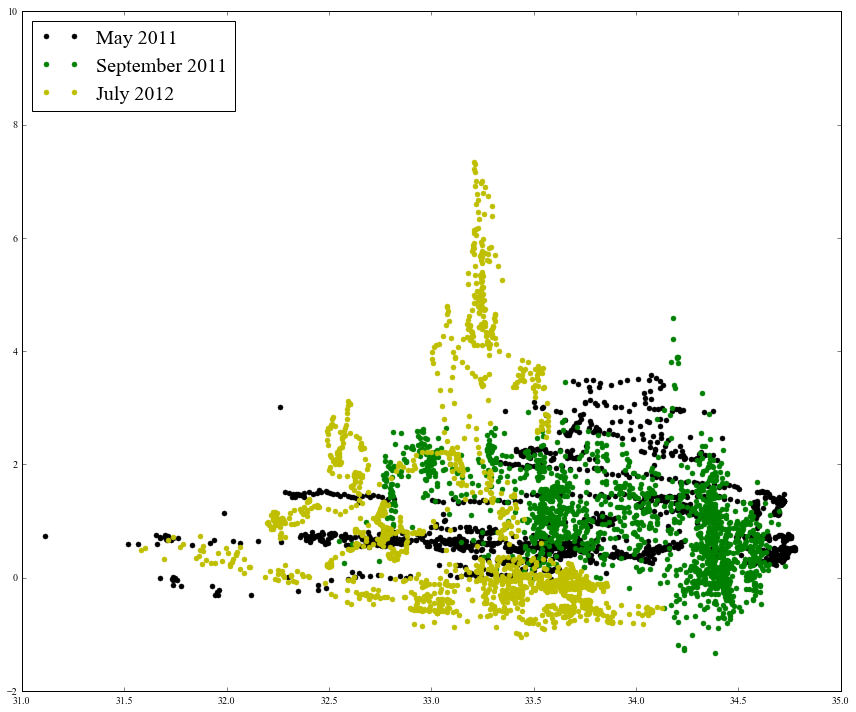

In [7]:
fig5 = plt.figure(5, figsize = (12, 10), dpi = 600)

plt.plot(Tok1['S'], Tok1['Air-sea flux']/np.mean(Tok1['Air-sea flux']), '.k', label = 'May 2011', markersize=10)
plt.plot(Tok3['S'], Tok3['Air-sea flux']/np.mean(Tok3['Air-sea flux']), '.g', label = 'September 2011', markersize=10)
plt.plot(Tian['S'], Tian['Air-sea flux']/np.mean(Tian['Air-sea flux']), '.y', label = 'July 2012', markersize=10)

plt.legend(loc = 'upper left', fontsize =20)
plt.axis([31,35,-2,10])
plt.show()